In [1]:
#------------------Laden und Überprüfen der Daten
import pandas as pd

# Laden der Excel-Datei
file_path = 'PSP_Jan_Feb_2019.xlsx'
data = pd.read_excel(file_path)

# Anzeigen der ersten Zeilen des Datensatzes
data.head()

,Unnamed: 0,tmsp,country,amount,success,PSP,3D_secured,card
0,0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [2]:
# Entfernen der 'Unnamed: 0'-Spalte
data = data.drop(columns=['Unnamed: 0'])

# Anzeigen der ersten Zeilen nach dem Entfernen der Spalte
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners


In [3]:
# Überprüfen auf fehlende Werte
missing_values = data.isnull().sum()
print("Fehlende Werte pro Spalte:\n", missing_values)

# Grundlegende Statistiken des Datensatzes
data.describe()

Fehlende Werte pro Spalte:
 tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64


,tmsp,amount,success,3D_secured
count,50410,50410.000000,50410.000000,50410.000000
mean,2019-01-29 16:28:52.923269120,202.395715,0.202896,0.238266
min,2019-01-01 00:01:11,6.000000,0.000000,0.000000
25%,2019-01-14 12:00:36.249999872,133.000000,0.000000,0.000000
50%,2019-01-30 15:20:07.500000,201.000000,0.000000,0.000000
75%,2019-02-13 01:09:50.500000,269.000000,0.000000,0.000000
max,2019-02-28 23:48:19,630.000000,1.000000,1.000000
std,NaN,96.274730,0.402160,0.426027


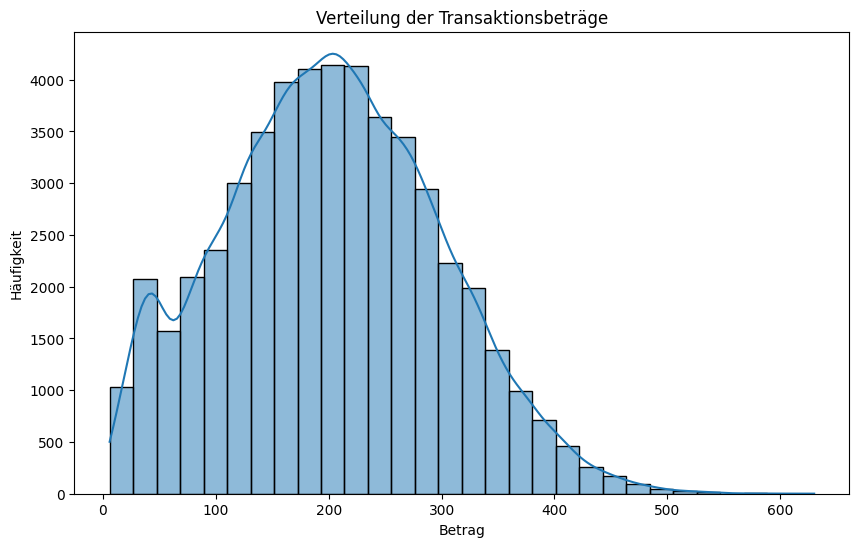

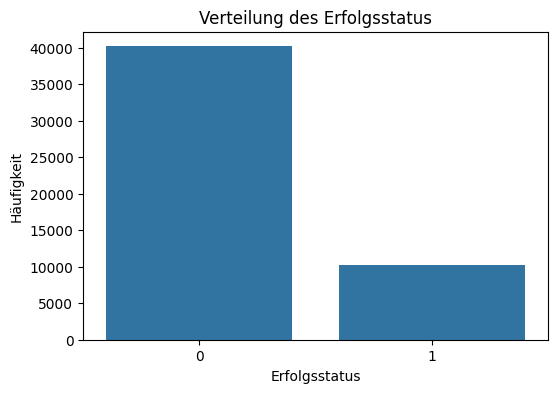

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Verteilung der Transaktionsbeträge
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=30, kde=True)
plt.title('Verteilung der Transaktionsbeträge')
plt.xlabel('Betrag')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung des Erfolgsstatus
plt.figure(figsize=(6, 4))
sns.countplot(x='success', data=data)
plt.title('Verteilung des Erfolgsstatus')
plt.xlabel('Erfolgsstatus')
plt.ylabel('Häufigkeit')
plt.show()

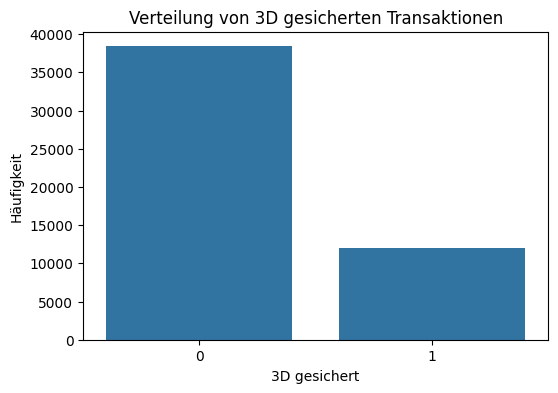

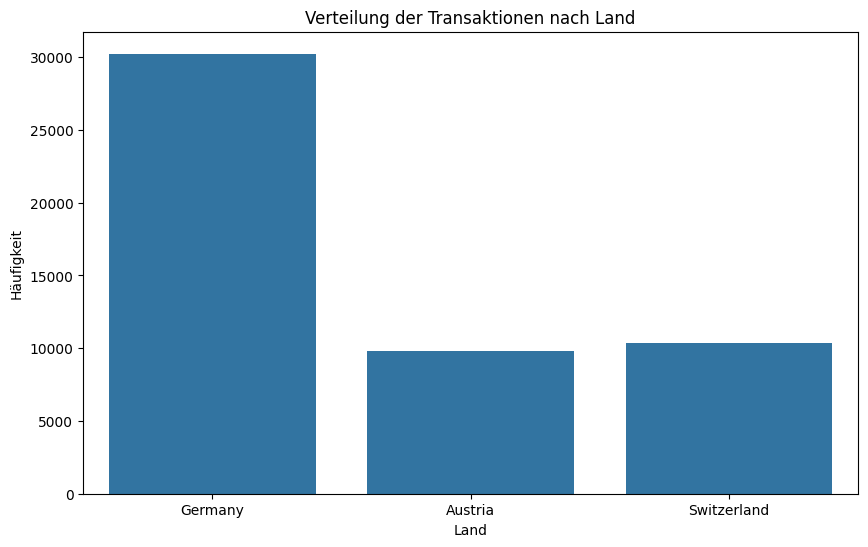

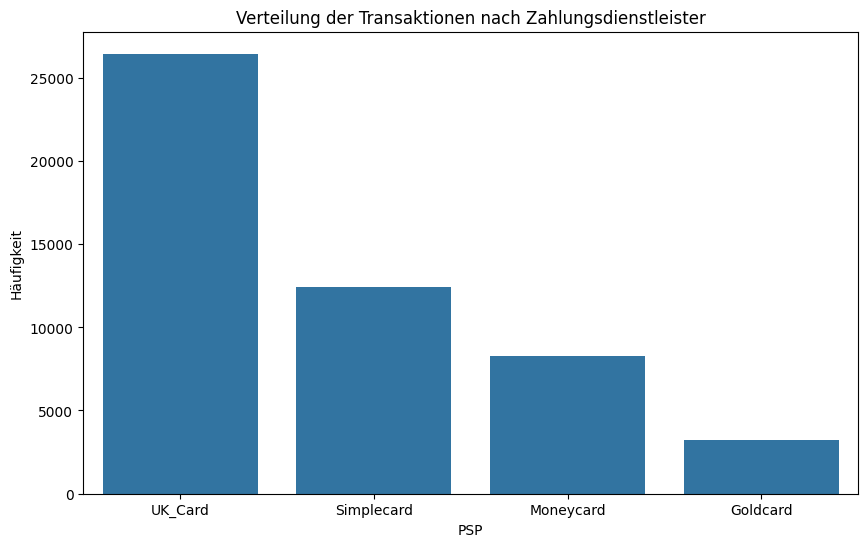

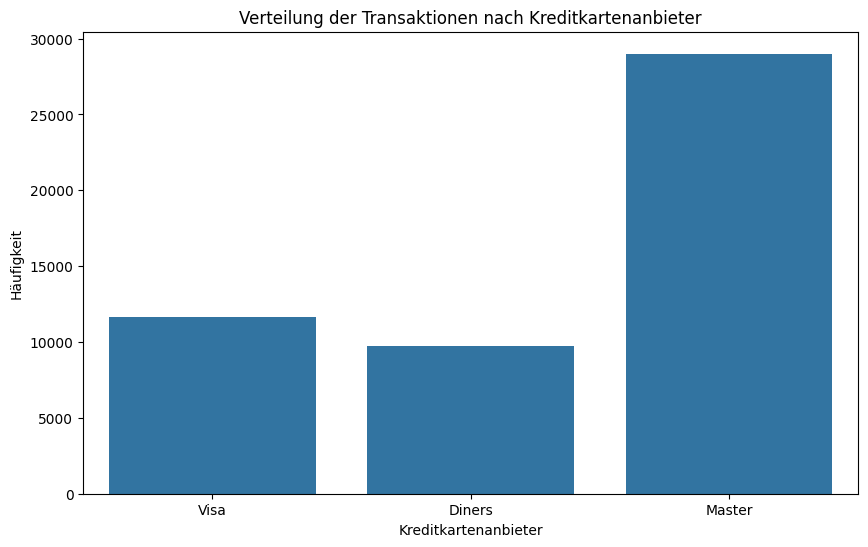

In [5]:
# Verteilung von 3D_secured
plt.figure(figsize=(6, 4))
sns.countplot(x='3D_secured', data=data)
plt.title('Verteilung von 3D gesicherten Transaktionen')
plt.xlabel('3D gesichert')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Land
plt.figure(figsize=(10, 6))
sns.countplot(x='country', data=data)
plt.title('Verteilung der Transaktionen nach Land')
plt.xlabel('Land')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Zahlungsdienstleister (PSP)
plt.figure(figsize=(10, 6))
sns.countplot(x='PSP', data=data)
plt.title('Verteilung der Transaktionen nach Zahlungsdienstleister')
plt.xlabel('PSP')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Kreditkartenanbieter
plt.figure(figsize=(10, 6))
sns.countplot(x='card', data=data)
plt.title('Verteilung der Transaktionen nach Kreditkartenanbieter')
plt.xlabel('Kreditkartenanbieter')
plt.ylabel('Häufigkeit')
plt.show()

In [6]:
# Anzahl der ursprünglichen Datensätze
original_count = len(data)

# Konvertieren des Zeitstempels in das datetime-Format
data['tmsp'] = pd.to_datetime(data['tmsp'])

# Sortieren der Daten nach 'country', 'amount' und 'tmsp'
data = data.sort_values(by=['country', 'amount', 'tmsp'])

# Berechnung der Zeitdifferenz zur vorherigen Transaktion in Sekunden
data['time_diff'] = data.groupby(['country', 'amount'])['tmsp'].diff().dt.total_seconds()

# Duplikate innerhalb einer Minute (60 Sekunden) entfernen
data = data[(data['time_diff'].isna()) | (data['time_diff'] > 60)]

# Anzahl der Datensätze nach dem Entfernen der Duplikate
new_count = len(data)

# Anzahl der entfernten Duplikate
removed_count = original_count - new_count

print(f"Ursprüngliche Anzahl der Datensätze: {original_count}")
print(f"Anzahl der Datensätze nach dem Entfernen der Duplikate: {new_count}")
print(f"Anzahl der entfernten Duplikate: {removed_count}")

# Entfernen der 'time_diff'-Spalte, da sie nicht mehr benötigt wird
data = data.drop(columns=['time_diff'])

# Anzeigen der ersten Zeilen nach dem Entfernen von Duplikaten
data.head()

Ursprüngliche Anzahl der Datensätze: 50410
Anzahl der Datensätze nach dem Entfernen der Duplikate: 27337
Anzahl der entfernten Duplikate: 23073


,tmsp,country,amount,success,PSP,3D_secured,card
9238,2019-01-10 03:49:12,Austria,6,0,Moneycard,0,Diners
22742,2019-01-27 14:01:11,Austria,6,1,Simplecard,0,Master
33737,2019-02-08 05:02:33,Austria,6,0,UK_Card,0,Diners
40539,2019-02-16 08:24:40,Austria,6,1,UK_Card,1,Master
21179,2019-01-25 04:18:26,Austria,7,0,Moneycard,0,Master


Fehlende Werte pro Spalte:
 tmsp          0
country       0
amount        0
success       0
PSP           0
3D_secured    0
card          0
dtype: int64


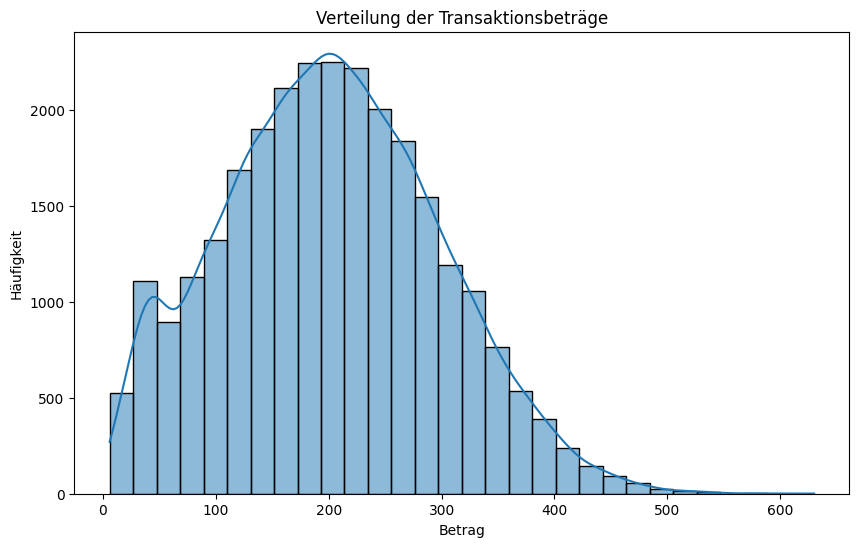

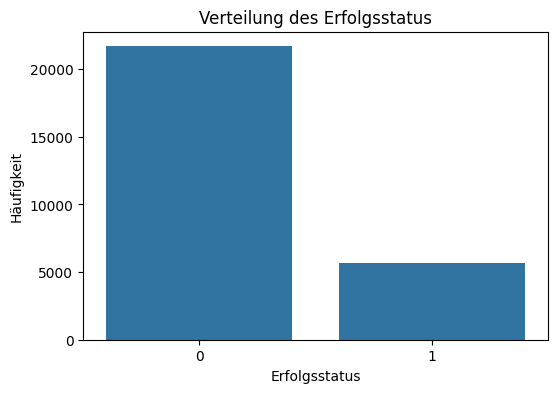

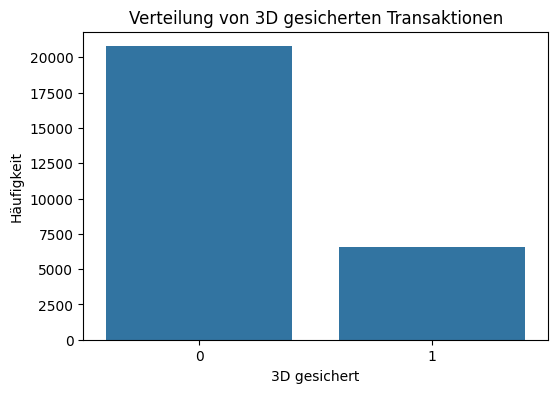

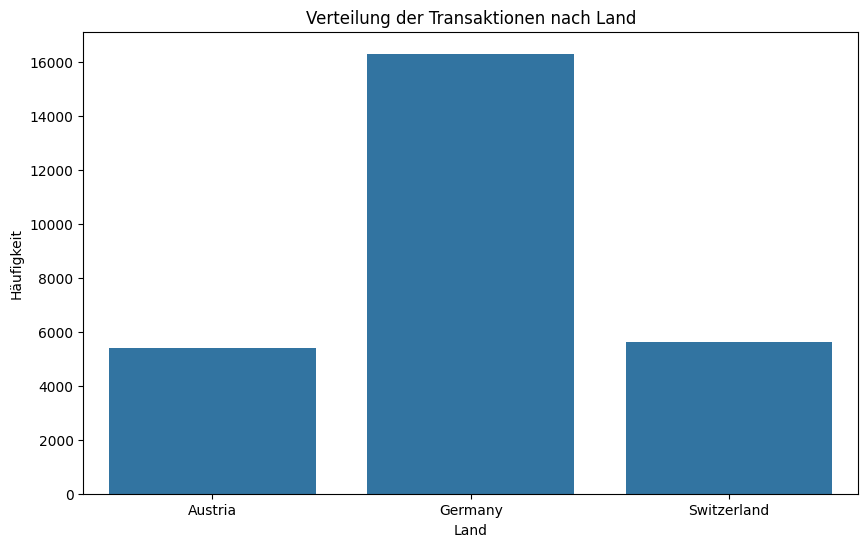

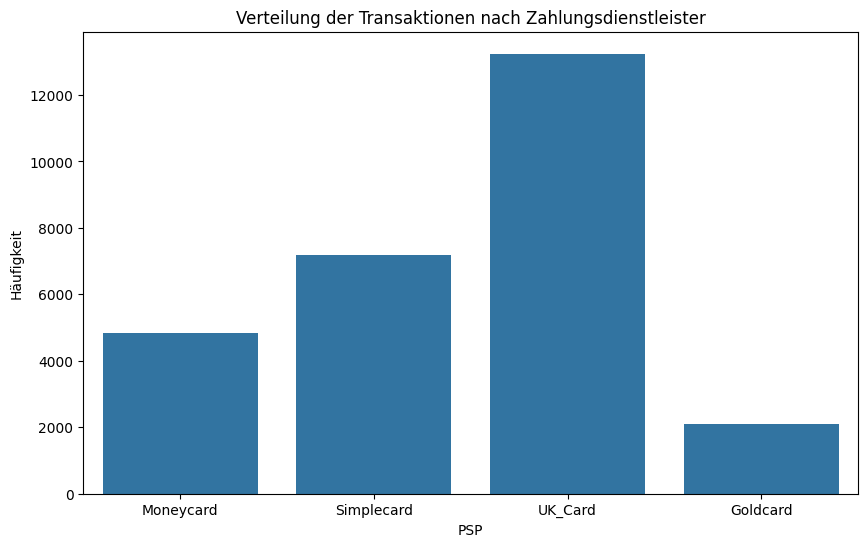

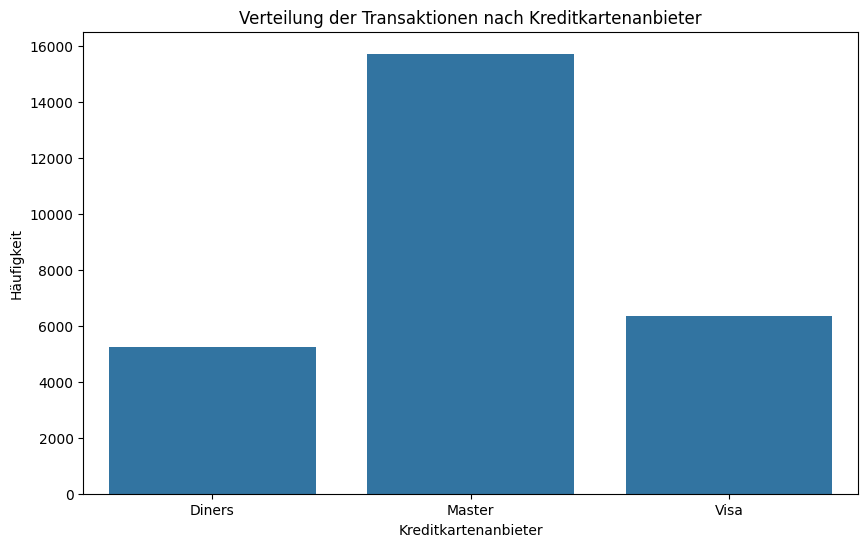

In [7]:
# Überprüfen auf fehlende Werte
missing_values = data.isnull().sum()
print("Fehlende Werte pro Spalte:\n", missing_values)

# Grundlegende Statistiken des Datensatzes
data.describe()

# Verteilung der Transaktionsbeträge
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['amount'], bins=30, kde=True)
plt.title('Verteilung der Transaktionsbeträge')
plt.xlabel('Betrag')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung des Erfolgsstatus
plt.figure(figsize=(6, 4))
sns.countplot(x='success', data=data)
plt.title('Verteilung des Erfolgsstatus')
plt.xlabel('Erfolgsstatus')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung von 3D_secured
plt.figure(figsize=(6, 4))
sns.countplot(x='3D_secured', data=data)
plt.title('Verteilung von 3D gesicherten Transaktionen')
plt.xlabel('3D gesichert')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Land
plt.figure(figsize=(10, 6))
sns.countplot(x='country', data=data)
plt.title('Verteilung der Transaktionen nach Land')
plt.xlabel('Land')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Zahlungsdienstleister (PSP)
plt.figure(figsize=(10, 6))
sns.countplot(x='PSP', data=data)
plt.title('Verteilung der Transaktionen nach Zahlungsdienstleister')
plt.xlabel('PSP')
plt.ylabel('Häufigkeit')
plt.show()

# Verteilung nach Kreditkartenanbieter
plt.figure(figsize=(10, 6))
sns.countplot(x='card', data=data)
plt.title('Verteilung der Transaktionen nach Kreditkartenanbieter')
plt.xlabel('Kreditkartenanbieter')
plt.ylabel('Häufigkeit')
plt.show()

In [8]:
# Überprüfen der Datentypen
print(data.dtypes)

# Sicherstellen, dass 'amount' numerisch ist
data['amount'] = pd.to_numeric(data['amount'], errors='coerce')

# Sicherstellen, dass 'tmsp' ein Datumstyp ist
data['tmsp'] = pd.to_datetime(data['tmsp'], errors='coerce')

tmsp          datetime64[ns]
country               object
amount                 int64
success                int64
PSP                   object
3D_secured             int64
card                  object
dtype: object


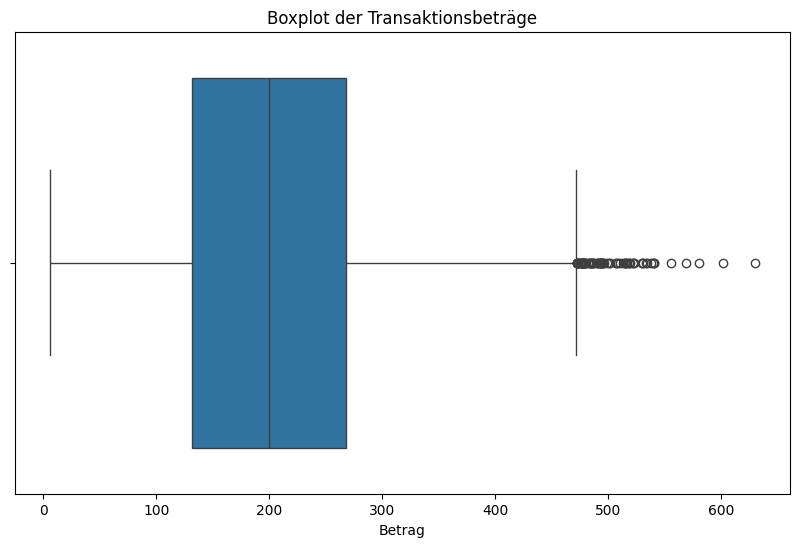

In [9]:
# Boxplot zur Identifikation von Ausreißern bei den Transaktionsbeträgen
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['amount'])
plt.title('Boxplot der Transaktionsbeträge')
plt.xlabel('Betrag')
plt.show()

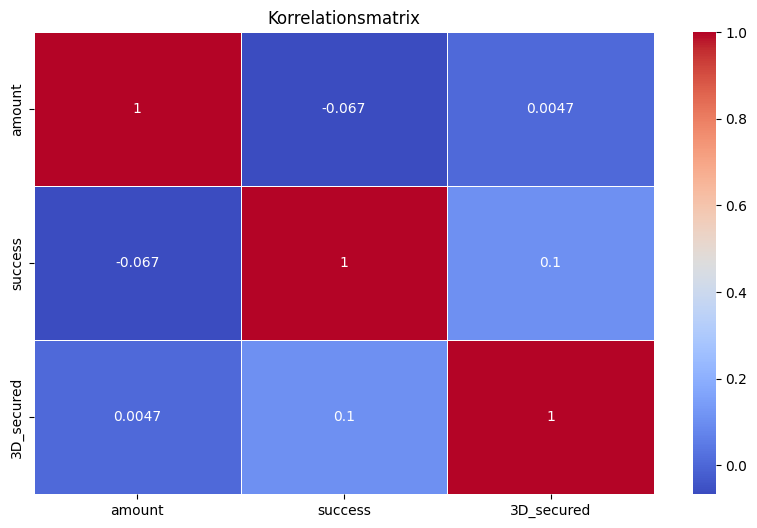

In [10]:
# Auswahl der numerischen Spalten
numeric_columns = data.select_dtypes(include=['number']).columns

# Korrelationen zwischen numerischen Variablen berechnen
correlation_matrix = data[numeric_columns].corr()

# Heatmap zur Visualisierung der Korrelationen
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korrelationsmatrix')
plt.show()

In [11]:
# Einzigartige Werte in den kategorischen Spalten anzeigen
print("Einzigartige Werte in 'country':", data['country'].unique())
print("Einzigartige Werte in 'PSP':", data['PSP'].unique())
print("Einzigartige Werte in 'card':", data['card'].unique())

Einzigartige Werte in 'country': ['Austria' 'Germany' 'Switzerland']
Einzigartige Werte in 'PSP': ['Moneycard' 'Simplecard' 'UK_Card' 'Goldcard']
Einzigartige Werte in 'card': ['Diners' 'Master' 'Visa']


In [12]:
#Datenaufbereitung für das Modell
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Auswahl der Merkmale (Features) und Zielvariable (Target)
X = data.drop(columns=['success', 'tmsp'])
y = data['success']

# Kategorische Variablen in Dummy-Variablen umwandeln
X = pd.get_dummies(X, drop_first=True)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisieren der numerischen Merkmale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
#Erstellen eines Baseline-Modells (Logistische Regression)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Erstellen und Trainieren des Modells
baseline_model = LogisticRegression(random_state=42)
baseline_model.fit(X_train, y_train)

# Vorhersagen auf dem Testset
y_pred = baseline_model.predict(X_test)
y_pred_prob = baseline_model.predict_proba(X_test)[:, 1]

Genauigkeit: 0.7990
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      4338
           1       0.64      0.06      0.11      1130

    accuracy                           0.80      5468
   macro avg       0.72      0.53      0.50      5468
weighted avg       0.77      0.80      0.73      5468



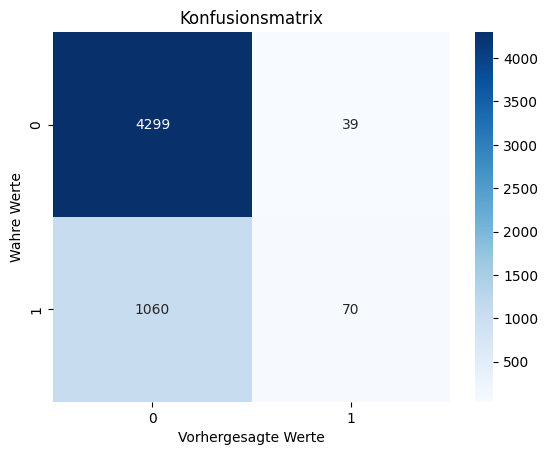

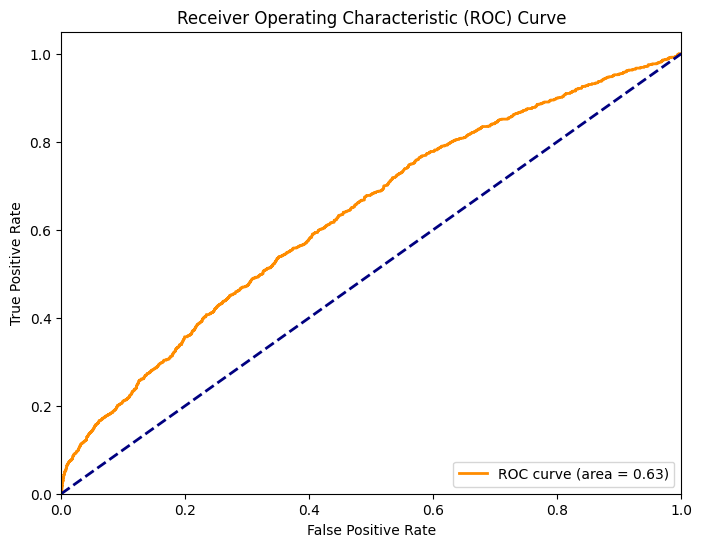

In [14]:
#Evaluierung des Baseline-Modells
# Berechnung der Metriken
accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit: {accuracy:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
#Feature-Engineering
# Erstellen neuer Features
data['hour'] = data['tmsp'].dt.hour
data['day_of_week'] = data['tmsp'].dt.dayofweek

# Auswahl der Merkmale (Features) und Zielvariable (Target)
X = data.drop(columns=['success', 'tmsp'])
y = data['success']

# Kategorische Variablen in Dummy-Variablen umwandeln
X = pd.get_dummies(X, drop_first=True)

# Aufteilen der Daten in Trainings- und Testsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisieren der numerischen Merkmale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Genauigkeit: 0.7983
Präzision: 0.6901
Recall: 0.0434
F1-Score: 0.0816
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      4338
           1       0.69      0.04      0.08      1130

    accuracy                           0.80      5468
   macro avg       0.74      0.52      0.48      5468
weighted avg       0.78      0.80      0.72      5468



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


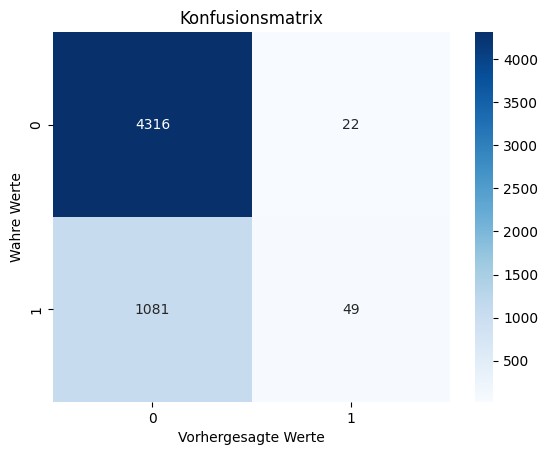

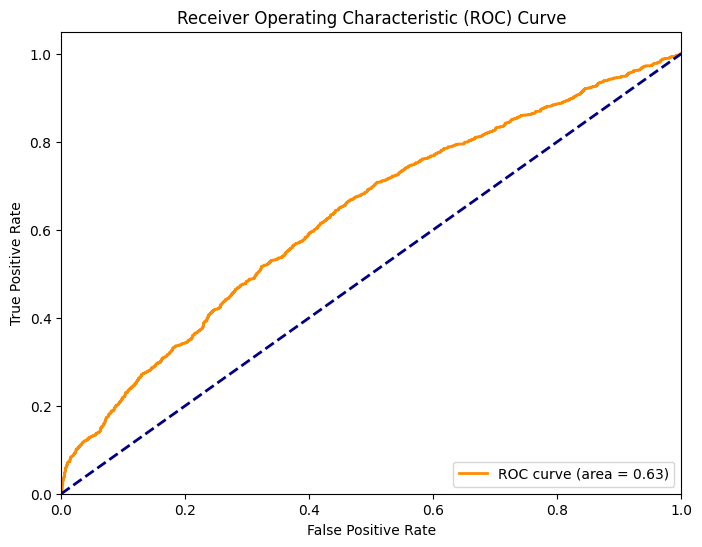

In [40]:
# Erstellung und Training des Modells
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, recall_score, precision_score

# Erstellen und Trainieren des Modells
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Vorhersagen auf dem Testset
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Berechnung der Metriken
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Genauigkeit: {accuracy:.4f}")
print(f"Präzision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred))

# Konfusionsmatrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Genauigkeit: 0.7462
Präzision: 0.3514
Recall: 0.2699
F1-Score: 0.3053


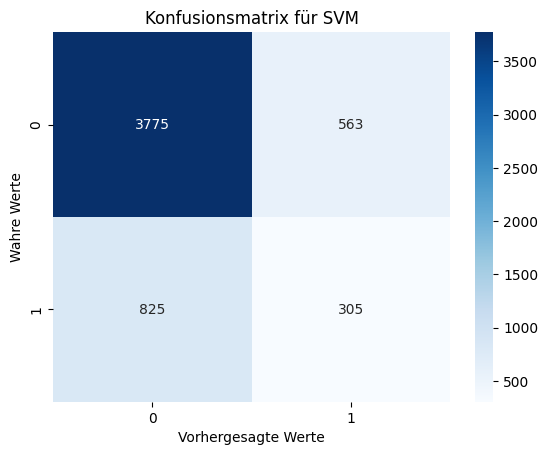

In [41]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# SMOTE anwenden
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardisieren der numerischen Merkmale nach SMOTE
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Erstellung des Modells
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_smote_scaled, y_train_smote)

# Vorhersage auf dem Testset
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Berechnung der Metriken
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print(f"Genauigkeit: {accuracy_svm:.4f}")
print(f"Präzision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")

# Konfusionsmatrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für SVM')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

Genauigkeit: 0.7244
Präzision: 0.3275
Recall: 0.3168
F1-Score: 0.3221
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83      4338
           1       0.33      0.32      0.32      1130

    accuracy                           0.72      5468
   macro avg       0.58      0.57      0.57      5468
weighted avg       0.72      0.72      0.72      5468



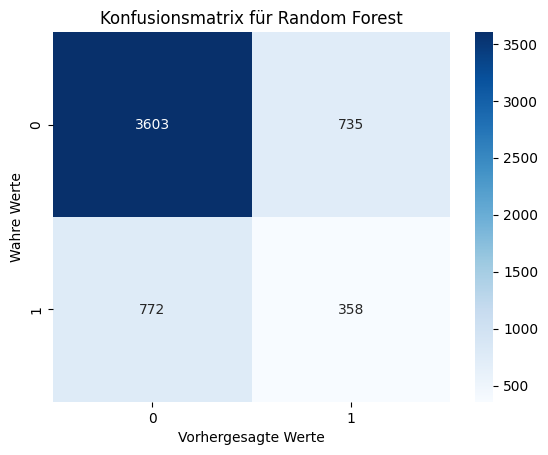

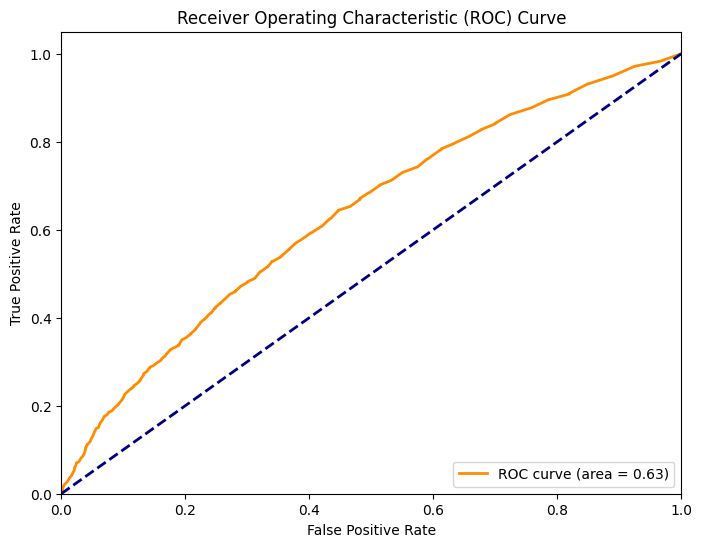

In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# SMOTE anwenden
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardisieren der numerischen Merkmale nach SMOTE
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Erstellung und Training des Random Forest Modells
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote_scaled, y_train_smote)

# Vorhersage auf dem Testset
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Berechnung der Metriken
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, zero_division=1)
recall_rf = recall_score(y_test, y_pred_rf, zero_division=1)
f1_rf = f1_score(y_test, y_pred_rf, zero_division=1)

print(f"Genauigkeit: {accuracy_rf:.4f}")
print(f"Präzision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_rf))

# Konfusionsmatrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für Random Forest')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_prob_rf)
roc_auc = roc_auc_score(y_test, y_pred_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Genauigkeit: 0.7303
Präzision: 0.3263
Recall: 0.3089
F1-Score: 0.3173
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83      8036
           1       0.33      0.31      0.32      2046

    accuracy                           0.73     10082
   macro avg       0.58      0.57      0.57     10082
weighted avg       0.72      0.73      0.73     10082



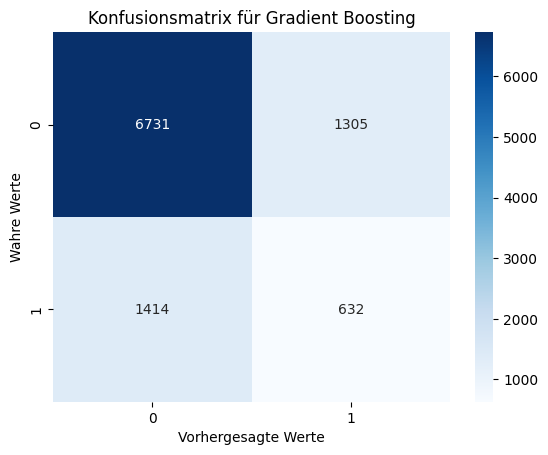

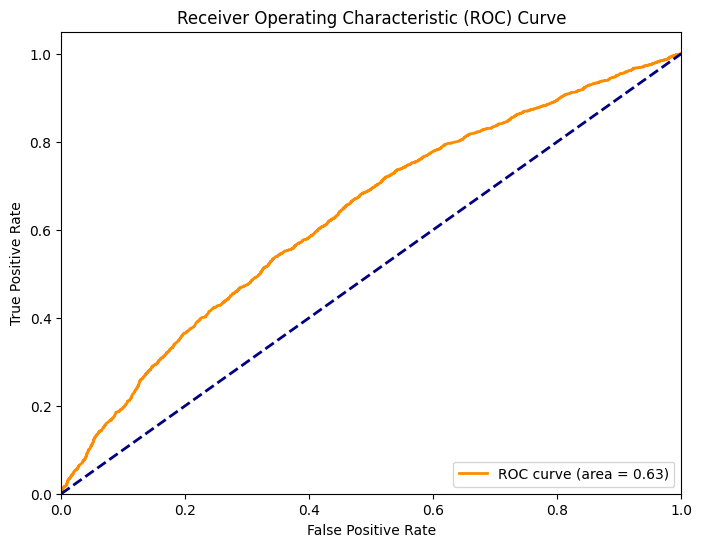

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# Laden der Excel-Datei
file_path = 'PSP_Jan_Feb_2019.xlsx'
data = pd.read_excel(file_path)

# Entfernen der 'Unnamed: 0'-Spalte
data = data.drop(columns=['Unnamed: 0'])

# Konvertieren des Zeitstempels in das datetime-Format
data['tmsp'] = pd.to_datetime(data['tmsp'])

# Feature Engineering
data['hour'] = data['tmsp'].dt.hour
data['day_of_week'] = data['tmsp'].dt.dayofweek

# Auswahl der Merkmale (Features) und Zielvariable (Target)
X = data.drop(columns=['success', 'tmsp'])
y = data['success']

# Kategorische Variablen in Dummy-Variablen umwandeln
X = pd.get_dummies(X, drop_first=True)

# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# SMOTE anwenden
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardisieren der numerischen Merkmale nach SMOTE
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Gradient Boosting Modell
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_smote_scaled, y_train_smote)

# Vorhersage auf dem Testset
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_prob_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

# Berechnung der Metriken
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb, zero_division=1)
recall_gb = recall_score(y_test, y_pred_gb, zero_division=1)
f1_gb = f1_score(y_test, y_pred_gb, zero_division=1)

print(f"Genauigkeit: {accuracy_gb:.4f}")
print(f"Präzision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-Score: {f1_gb:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_gb))

# Konfusionsmatrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für Gradient Boosting')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_gb)
roc_auc = roc_auc_score(y_test, y_pred_prob_gb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Genauigkeit: 0.7272
Präzision: 0.3206
Recall: 0.3074
F1-Score: 0.3139
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      8036
           1       0.32      0.31      0.31      2046

    accuracy                           0.73     10082
   macro avg       0.57      0.57      0.57     10082
weighted avg       0.72      0.73      0.73     10082



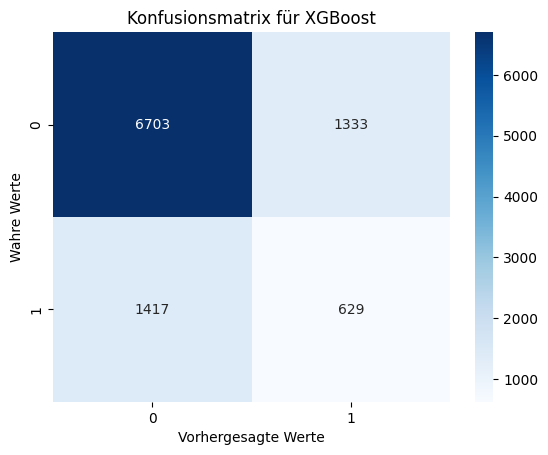

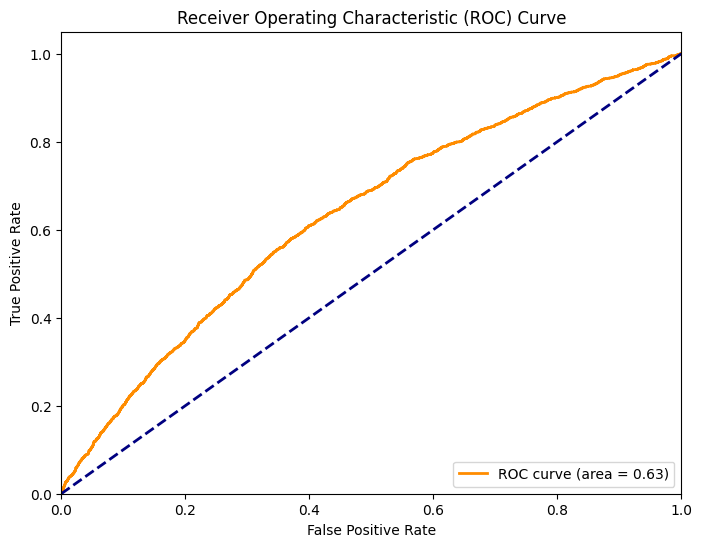

In [44]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# SMOTE anwenden
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardisieren der numerischen Merkmale nach SMOTE
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# XGBoost Modell
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train_smote_scaled, y_train_smote)

# Vorhersage auf dem Testset
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Berechnung der Metriken
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb, zero_division=1)
recall_xgb = recall_score(y_test, y_pred_xgb, zero_division=1)
f1_xgb = f1_score(y_test, y_pred_xgb, zero_division=1)

print(f"Genauigkeit: {accuracy_xgb:.4f}")
print(f"Präzision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-Score: {f1_xgb:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_xgb))

# Konfusionsmatrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für XGBoost')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_xgb)
roc_auc = roc_auc_score(y_test, y_pred_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

[LightGBM] [Info] Number of positive: 32146, number of negative: 32146
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 64292, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Genauigkeit: 0.7411
Präzision: 0.3428
Recall: 0.3006
F1-Score: 0.3203
Klassifikationsbericht:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      8036
           1       0.34      0.30      0.32      2046

    accuracy                           0.74     10082
   macro avg       0.59      0.58      0.58     10082
weighted avg       0.73      0.74      0.73     10082



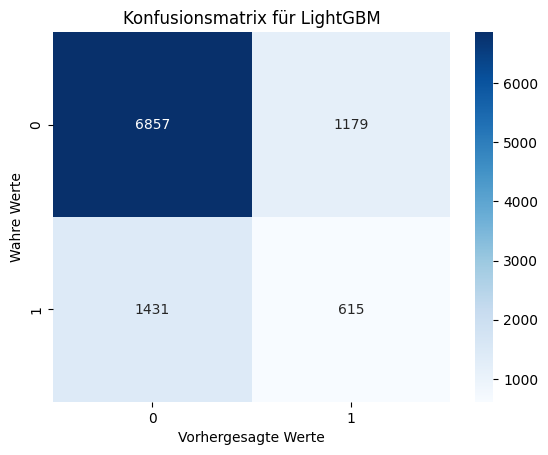

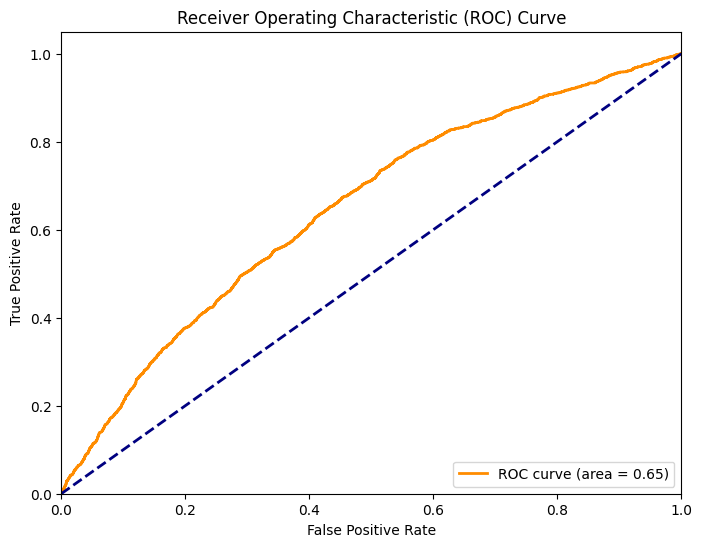

In [45]:
import lightgbm as lgb

# LightGBM Modell
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_smote_scaled, y_train_smote)

# Vorhersage auf dem Testset
y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_prob_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

# Berechnung der Metriken
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb, zero_division=1)
recall_lgb = recall_score(y_test, y_pred_lgb, zero_division=1)
f1_lgb = f1_score(y_test, y_pred_lgb, zero_division=1)

print(f"Genauigkeit: {accuracy_lgb:.4f}")
print(f"Präzision: {precision_lgb:.4f}")
print(f"Recall: {recall_lgb:.4f}")
print(f"F1-Score: {f1_lgb:.4f}")

print("Klassifikationsbericht:")
print(classification_report(y_test, y_pred_lgb))

# Konfusionsmatrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(conf_matrix_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für LightGBM')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

# ROC-Kurve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_lgb)
roc_auc = roc_auc_score(y_test, y_pred_prob_lgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.9s
[CV] END m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_esti

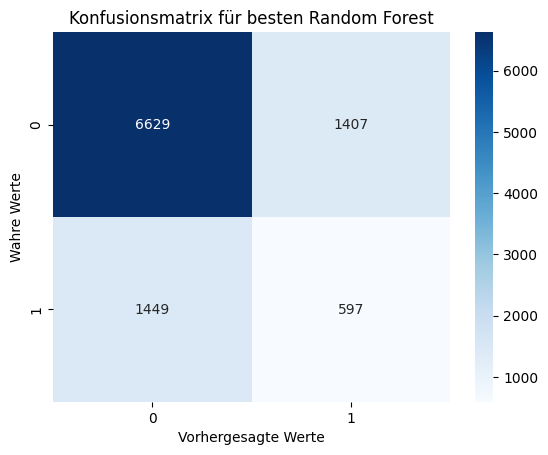

In [46]:
# Definieren des erweiterten Hyperparameter-Bereichs
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV zur Hyperparameter-Suche
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_smote_scaled, y_train_smote)

# Beste Hyperparameter
best_params_rf = grid_search_rf.best_params_
print(f"Beste Hyperparameter für Random Forest: {best_params_rf}")

# Modell mit besten Hyperparametern trainieren
best_rf_model = grid_search_rf.best_estimator_

# Vorhersage auf dem Testset
y_pred_best_rf = best_rf_model.predict(X_test_scaled)
y_pred_prob_best_rf = best_rf_model.predict_proba(X_test_scaled)[:, 1]

# Bewertung der Modellleistung
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf, zero_division=1)
recall_best_rf = recall_score(y_test, y_pred_best_rf, zero_division=1)
f1_best_rf = f1_score(y_test, y_pred_best_rf, zero_division=1)

print("Beste Random Forest Ergebnisse:")
print(f"Genauigkeit: {accuracy_best_rf:.4f}")
print(f"Präzision: {precision_best_rf:.4f}")
print(f"Recall: {recall_best_rf:.4f}")
print(f"F1-Score: {f1_best_rf:.4f}")

# Konfusionsmatrix
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)
sns.heatmap(conf_matrix_best_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für besten Random Forest')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Number of positive: 25717, number of negative: 25717
[LightGBM] [Info] Number of positive: 25717, number of negative: 25717
[LightGBM] [Info] Number of positive: 25717, number of negative: 25716
[LightGBM] [Info] Number of positive: 25717, number of negative: 25716
[LightGBM] [Info] Number of positive: 25717, number of negative: 25717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of positive: 25717, number of negative: 25717
[LightGBM] [Info] Number of

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END boosting_type=gbdt, learning_rate=0.2, n_estimators=200, num_leaves=100; total time=  32.7s
[LightGBM] [Info] Number of positive: 25717, number of negative: 25716
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 312
[LightGBM] [Info] Number of data points in the train set: 51433, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500010 -> initscore=0.000039
[LightGBM] [Info] Start training from score 0.000039
[CV] END boosting_type=dart, learning_rate=0.01, n_estimators=50, num_leaves=100; total time=   9.8s
[CV] END boosting_type=gbdt, learning_rate=0.2, n_estimators=200, num_leaves=100; total time=  33.2s
[LightGBM] [Info] Number of positive: 25717, number of negative: 25717
[LightGBM] [Info] Number of positive: 25716, number of negative: 25717


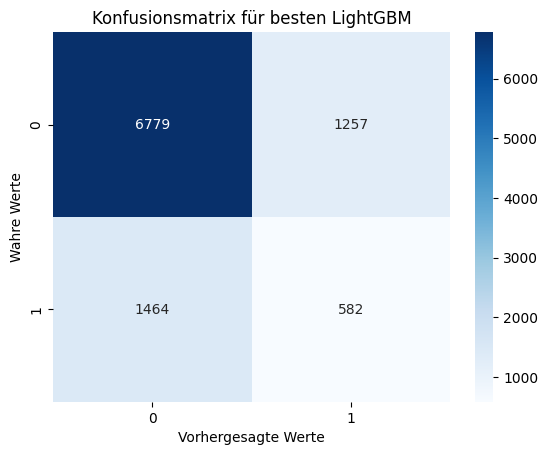

In [47]:
# Definieren des erweiterten Hyperparameter-Bereichs
param_grid_lgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'boosting_type': ['gbdt', 'dart']
}

# GridSearchCV zur Hyperparameter-Suche
grid_search_lgb = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42), param_grid=param_grid_lgb, cv=5, scoring='f1', n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train_smote_scaled, y_train_smote)

# Beste Hyperparameter
best_params_lgb = grid_search_lgb.best_params_
print(f"Beste Hyperparameter für LightGBM: {best_params_lgb}")

# Modell mit besten Hyperparametern trainieren
best_lgb_model = grid_search_lgb.best_estimator_

# Vorhersage auf dem Testset
y_pred_best_lgb = best_lgb_model.predict(X_test_scaled)
y_pred_prob_best_lgb = best_lgb_model.predict_proba(X_test_scaled)[:, 1]

# Bewertung der Modellleistung
accuracy_best_lgb = accuracy_score(y_test, y_pred_best_lgb)
precision_best_lgb = precision_score(y_test, y_pred_best_lgb, zero_division=1)
recall_best_lgb = recall_score(y_test, y_pred_best_lgb, zero_division=1)
f1_best_lgb = f1_score(y_test, y_pred_best_lgb, zero_division=1)

print("Beste LightGBM Ergebnisse:")
print(f"Genauigkeit: {accuracy_best_lgb:.4f}")
print(f"Präzision: {precision_best_lgb:.4f}")
print(f"Recall: {recall_best_lgb:.4f}")
print(f"F1-Score: {f1_best_lgb:.4f}")

# Konfusionsmatrix
conf_matrix_best_lgb = confusion_matrix(y_test, y_pred_best_lgb)
sns.heatmap(conf_matrix_best_lgb, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix für besten LightGBM')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()

In [48]:
# Definition der Gebührenstruktur
fee_structure = {
    'Moneycard': {'success': 5, 'failure': 2},
    'Goldcard': {'success': 10, 'failure': 5},
    'UK_Card': {'success': 3, 'failure': 1},
    'Simplecard': {'success': 1, 'failure': 0.5}
}

# Berechnung der tatsächlichen Gebühren
data['fee'] = data.apply(lambda row: fee_structure[row['PSP']]['success'] if row['success'] == 1 else fee_structure[row['PSP']]['failure'], axis=1)

# Berechnung der Gebühren basierend auf den Vorhersagen des besten Modells (LightGBM)
data['predicted_success'] = best_lgb_model.predict(scaler.transform(pd.get_dummies(data.drop(columns=['success', 'tmsp', 'fee']), drop_first=True)))
data['predicted_fee'] = data.apply(lambda row: fee_structure[row['PSP']]['success'] if row['predicted_success'] == 1 else fee_structure[row['PSP']]['failure'], axis=1)

# Summierung der tatsächlichen und vorhergesagten Gebühren
actual_total_fee = data['fee'].sum()
predicted_total_fee = data['predicted_fee'].sum()

print(f"Tatsächliche Gesamtkosten: {actual_total_fee}")
print(f"Vorhergesagte Gesamtkosten: {predicted_total_fee}")

Tatsächliche Gesamtkosten: 88544.0
Vorhergesagte Gesamtkosten: 92119.0


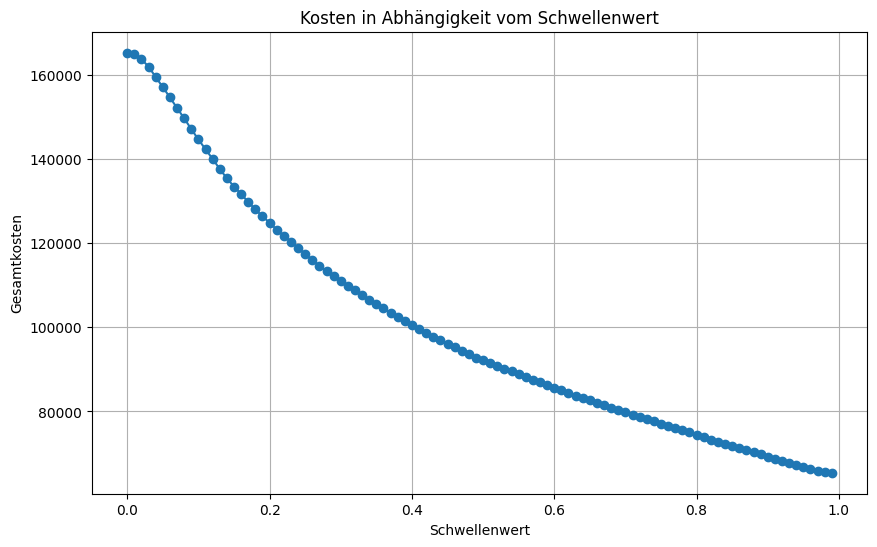

Optimaler Schwellenwert: 0.99
Minimale Gesamtkosten: 65401.0


ValueError: Found input variables with inconsistent numbers of samples: [10082, 50410]

In [50]:
import numpy as np

# Berechnung der Wahrscheinlichkeiten
thresholds = np.arange(0.0, 1.0, 0.01)
fees = []

# Kopieren des Original-Datensatzes, um die Vorhersagen durchzuführen
data_for_predictions = data.copy()

# Entfernen der Spalten 'predicted_fee' und 'predicted_success', falls vorhanden
if 'predicted_fee' in data_for_predictions.columns:
    data_for_predictions = data_for_predictions.drop(columns=['predicted_fee'])
if 'predicted_success' in data_for_predictions.columns:
    data_for_predictions = data_for_predictions.drop(columns=['predicted_success'])

# Entfernen der Spalte 'fee', falls vorhanden
if 'fee' in data_for_predictions.columns:
    data_for_predictions = data_for_predictions.drop(columns=['fee'])

# Identifizieren der Features, die während des Trainings verwendet wurden
original_features = X.columns

for threshold in thresholds:
    # Daten ohne Zielvariable und Datumsinformationen vorbereiten
    X_data = data_for_predictions.drop(columns=['success', 'tmsp'])
    X_data = pd.get_dummies(X_data, drop_first=True)
    
    # Sicherstellen, dass die Reihenfolge der Spalten übereinstimmt
    X_data = X_data.reindex(columns=original_features, fill_value=0)
    
    # Skalierung der Daten
    X_data = scaler.transform(X_data)
    
    # Vorhersage der Erfolgswahrscheinlichkeit
    data_for_predictions['predicted_success'] = (best_lgb_model.predict_proba(X_data)[:, 1] >= threshold).astype(int)
    
    # Berechnung der vorhergesagten Gebühren
    data_for_predictions['predicted_fee'] = data_for_predictions.apply(
        lambda row: fee_structure[row['PSP']]['success'] if row['predicted_success'] == 1 else fee_structure[row['PSP']]['failure'], axis=1
    )
    
    # Summierung der vorhergesagten Gebühren
    total_fee = data_for_predictions['predicted_fee'].sum()
    fees.append(total_fee)

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fees, marker='o')
plt.title('Kosten in Abhängigkeit vom Schwellenwert')
plt.xlabel('Schwellenwert')
plt.ylabel('Gesamtkosten')
plt.grid(True)
plt.show()

# Finden des optimalen Schwellenwerts
optimal_threshold_index = np.argmin(fees)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_fee = fees[optimal_threshold_index]

print(f"Optimaler Schwellenwert: {optimal_threshold}")
print(f"Minimale Gesamtkosten: {optimal_fee}")

# Bewertung der Modellleistung bei optimalem Schwellenwert
data_for_predictions['predicted_success'] = (best_lgb_model.predict_proba(X_data)[:, 1] >= optimal_threshold).astype(int)
y_pred_optimal = data_for_predictions['predicted_success']

accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
precision_optimal = precision_score(y_test, y_pred_optimal, zero_division=1)
recall_optimal = recall_score(y_test, y_pred_optimal, zero_division=1)
f1_optimal = f1_score(y_test, y_pred_optimal, zero_division=1)

print(f"Genauigkeit: {accuracy_optimal:.4f}")
print(f"Präzision: {precision_optimal:.4f}")
print(f"Recall: {recall_optimal:.4f}")
print(f"F1-Score: {f1_optimal:.4f}")

# Konfusionsmatrix
conf_matrix_optimal = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(conf_matrix_optimal, annot=True, fmt='d', cmap='Blues')
plt.title('Konfusionsmatrix bei optimalem Schwellenwert für LightGBM')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Wahre Werte')
plt.show()